In [3]:
# ウェブトラフィック量の未来予測を最終目標として、モデルパラメータの推定などを実践
# データのロード
import scipy as sp
data = sp.genfromtxt("data/web_traffic.tsv", delimiter="\t")
# このデータは1時間毎のウェブトラフィック量を記録したもの
# 1列目：時間
# 2列目：トラフィック量
print(data[:10])
print(data.shape)

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]
(743, 2)


In [4]:
# 元のデータを2つのベクトルに分離
x = data[:,0]
y = data[:,1]

In [5]:
# dataにはnanが含まれている
sp.sum(sp.isnan(y))

8

In [6]:
# nan以外のデータのみを取り扱う
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

<IPython.core.display.Javascript object>


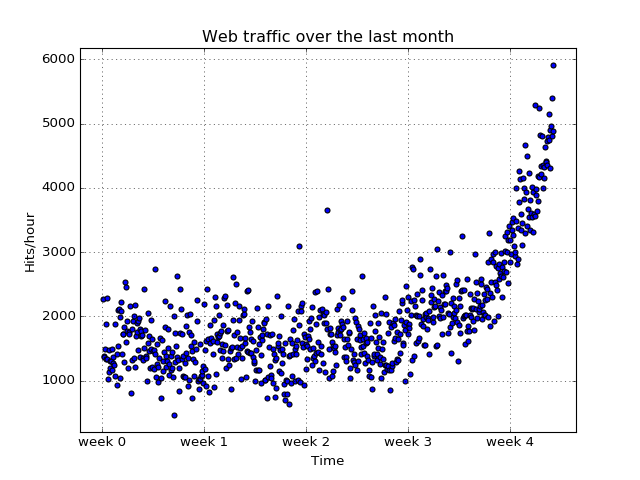

In [7]:
# Matplotlibを使ってデータの散布図を描画
# jupyter-notebook内にmatplotlibの内容を表示させる場合には%matplotlib inline, matplotlib notebookが必要
%matplotlib notebook
import matplotlib.pyplot as plt
# 元データの散布図は何度も描画するので関数化して使用
def createScatter():    
    plt.scatter(x,y)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(10)],["week {0:d}".format(w) for w in range(10)])
    plt.autoscale(tight=True)
    plt.grid()
    return plt
plt = createScatter()
plt.show()

In [8]:
# モデルの構築のための誤差関数定義
def error(f,x,y):
    return sp.sum((f(x)-y) ** 2)

In [9]:
# 直線近似(多項式近似の次元を1にセット)
fp1, residuals, rank, sv, rcond = sp.polyfit(x,y,1, full=True)

In [10]:
# 直線近似した場合のパラメータを確認
print("Model parameters: {0}".format(fp1))

Model parameters: [   2.59619213  989.02487106]


In [11]:
# 近似誤差
print(residuals)

[  3.17389767e+08]


In [12]:
# poly1d()にパラメータを与えるとモデル関数を作れるので、自作したerror()にモデル関数とデータを与えると誤差関数の結果が求められる
# residualsと同じになっていることを確認
f1 = sp.poly1d(fp1)
print(error(f1,x,y))

317389767.34


<IPython.core.display.Javascript object>


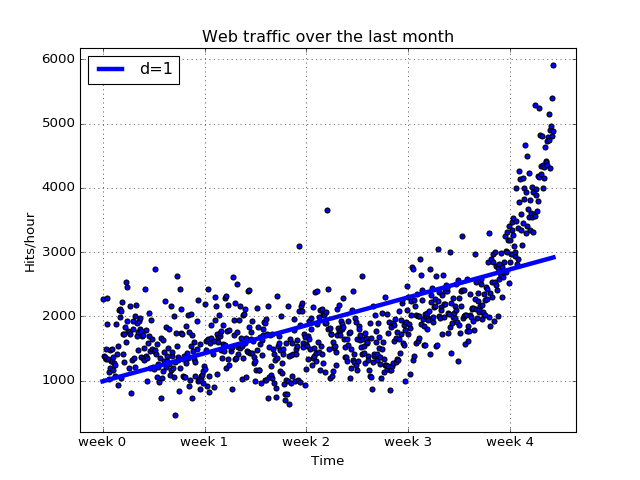

In [13]:
# 求めた直線をグラフに描画
plt = createScatter()
# 直線
fx = sp.linspace(0, x[-1], 1000)
plt.plot(fx, f1(fx), linewidth=4)
plt.legend(["d={}".format(f1.order)], loc="upper left")
plt.show()

In [14]:
# 二次多項式でフィッティングしてみる
# 先程はfull = Trueにしていたため、多くの出力値を得られたが、特に指定しなければパラメータだけが求まる
f2p = sp.polyfit(x, y, 2)
f2p

array([  1.05322215e-02,  -5.26545650e+00,   1.97476082e+03])

In [15]:
# モデルパラメータからモデル関数を作成し、誤差を求める
# 直線近似の時よりは誤差が減っていて良い
f2 = sp.poly1d(f2p)
print(error(f2,x,y))

179983507.878


In [16]:
# その他の多項式近似結果も見てみる。一番複雑なモデルが(一応)誤差は少ない。(が、過学習しているのがグラフ描画で確認できる)
# なお、描画用に関数を保存しておく
# (次元が多すぎると劣決定問題で警告がでている?)
dims = [1,2,3,10,100]
funcs = []
for d in dims:
    fdp = sp.polyfit(x,y,d)
    fd = sp.poly1d(fdp)
    funcs.append(fd)
    err = error(fd, x, y)
    print("Error d={0}: {1}".format(d,err))


Error d=1: 317389767.33977807
Error d=2: 179983507.8781792
Error d=3: 139350144.03172523
Error d=10: 121942326.36354844
Error d=100: 109452411.76838967


/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


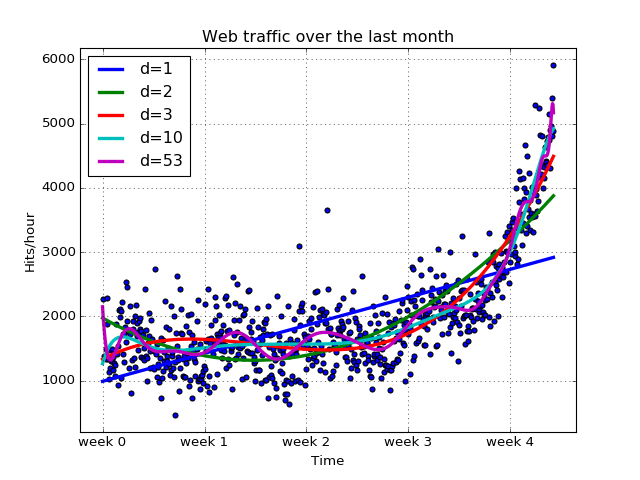

In [17]:
# 各関数を描画する。高次元だと過学習になっている点に注目。
#  散布図
plt = createScatter()
# 各関数を描画
fx = sp.linspace(0, x[-1], 1000)
for f in funcs:
    plt.plot(fx, f(fx), linewidth=3)

plt.legend(["d={}".format(f.order) for f in funcs], loc="upper left")
plt.show()

In [18]:
# 3.5週を境に性質が変わっている事を仮定して、分割して処理してみる
inflection = int(3.5*7*24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa,ya,1))
fb = sp.poly1d(sp.polyfit(xb,yb,1))

fa_error = error(fa,xa,ya)
fb_error = error(fb,xb,yb)
sum_error = fa_error+fb_error
print("Error inflection={0}".format(sum_error))

Error inflection=132950348.19761637


<IPython.core.display.Javascript object>


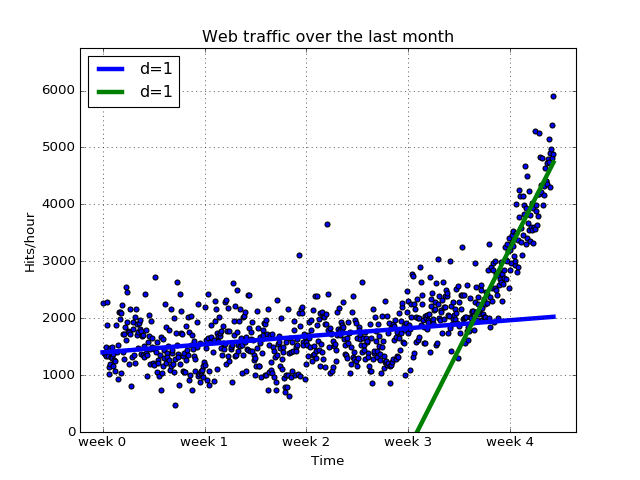

In [19]:
# 2つの直線を描画
plt = createScatter()
# 直線
fx = sp.linspace(0, x[-1], 1000)
plt.plot(fx, fa(fx), linewidth=4)
plt.plot(fx, fb(fx), linewidth=4)
plt.legend(["d={}".format(fa.order),"d={}".format(fb.order)], loc="upper left")
plt.ylim(ymin=0) # 表示を見やすくするため yの下限を0に設定する
plt.show()

<IPython.core.display.Javascript object>


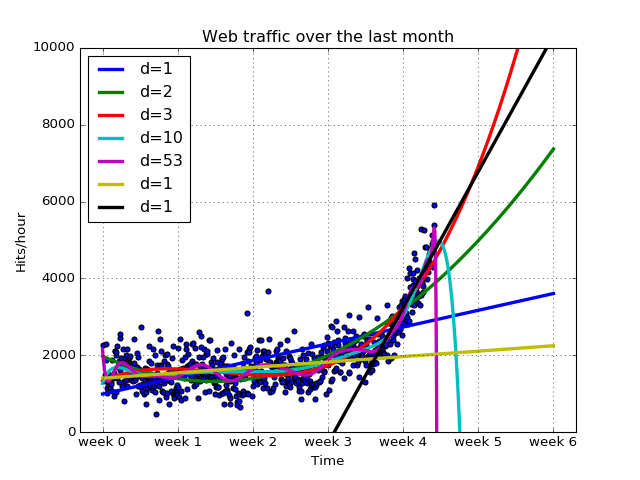

In [20]:
# xの範囲を延長して、得ている関数で未来予測をしてみる
# 第六週まで見ることにする (xの範囲をfxで再度定義)
plt = createScatter()
future = int(6*7*24)
fx = sp.linspace(0, future, 1000)
# 過去の関数を一度リスト化
all_funcs = []
for f in funcs:
    all_funcs.append(f)
all_funcs.append(fa)
all_funcs.append(fb)
# 全関数を描画
for f in all_funcs:
    plt.plot(fx, f(fx), linewidth=3)
plt.ylim(ymin=0,ymax=10000) # 表示を見やすくするため yの下限を0に設定する
plt.legend(["d={}".format(f.order) for f in all_funcs], loc="upper left")
plt.show()

In [26]:
# 学習の範囲を3.5週以降にして再度モデルを学習してみる
# 依然として誤差だけを見ると一番複雑なモデルがベストに見えてしまう。
# dims = [1,2,3,10,100]
# inflection = int(3.5*7*24)
# xb = x[inflection:]
# yb = y[inflection:]
all_funcs_inflection = []
for d in dims:
    f = sp.poly1d(sp.polyfit(xb,yb,d))
    all_funcs_inflection.append(f)
    err = error(f, xb, yb)
    print("Error d={0}: {1}".format(d,err))

Error d=1: 22143941.107618243
Error d=2: 19768846.98917637
Error d=3: 19766452.361026973
Error d=10: 18949296.78433668
Error d=100: 18300791.400089264


/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


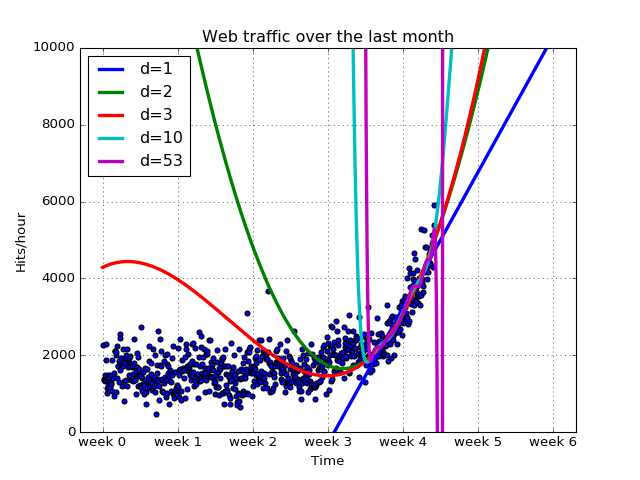

In [24]:
plt = createScatter()
# 全関数を描画
for f in all_funcs_inflection:
    plt.plot(fx, f(fx), linewidth=3)
plt.ylim(ymin=0,ymax=10000) # 表示を見やすくするため yの下限を0に設定する
plt.legend(["d={}".format(f.order) for f in all_funcs_inflection], loc="upper left")
plt.show()

In [43]:
# 訓練データとテストデータを分けて評価を行う
# 全体の30%をテスト用データとする
frac = 0.3
split_idx = int(frac * len(xb))
# 全データの30%をランダムに選び出す
# testとtrainには元データxbに対応するインデックスが入っている
shuffled = sp.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])

In [44]:
# 訓練データを用いて学習し、テストデータを用いて評価する
# 二次多項式でのモデル化が最も適していることが確認できる。
# (学習時に含まれていなかった)未知のデータに対して頑健なモデルであることから、未来予測にも適しているといえる。
all_funcs_train = []
x_train = xb[train]
y_train = yb[train]
x_test = xb[test]
y_test = yb[test]
for d in dims:
    # 訓練データで学習
    f = sp.poly1d(sp.polyfit(x_train,y_train,d))
    all_funcs_train.append(f)
    # テストデータで評価
    err = error(f, x_test, y_test)
    print("Error d={0}: {1}".format(d,err))

Error d=1: 4971012.746862981
Error d=2: 4345597.799635091
Error d=3: 4377236.055819814
Error d=10: 4398576.941692352
Error d=100: 4623823.9794204235


/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/kengo/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [45]:
# 時間あたりのリクエスト数が、いつ100000を超えるのか予想する
# 二次多項式から100000を引いて、0になるxを解として求めればOK
# まずは使用する関数を確認
func_best = all_funcs_train[1]
print(func_best)
# 解きたい方程式
print(func_best-100000)

         2
0.08052 x - 86.81 x + 2.507e+04
         2
0.08052 x - 86.81 x - 7.493e+04


In [47]:
# 上記の解を求めるためにSciPyのfsolve()が使用できる。初期値を与えれば最適化計算で解が求まる。
from scipy.optimize import fsolve
reached_max = fsolve(func_best-100000, 800)
# weekで表示できるように正規化
reached_max /= (7*24)
# ウェブトラフィック量が100,000を超えるのは、9~10週頃だとわかった！
print("100,000 hits/hour expected at week {0}".format(reached_max[0]))

100,000 hits/hour expected at week 9.785890094865536
